Perform Exploratory Data Analysis (EDA) analysis on the following:

- Summary Statistics & Missing-Value Report


In [4]:
#Step 1: Import Libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from windrose import WindroseAxes


ModuleNotFoundError: No module named 'windrose'

In [13]:
class Config:
    DATA_PATH = "../data/benin-malanville.csv"
    OUTPUT_PATH = "../data/benin_clean.csv"
    KEY_COLUMNS = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
    THRESHOLD = 0.05


In [14]:
#Step 2: Define a DataProfiler Class
class DataProfiler:
    def __init__(self, filepath):
        self.filepath = filepath
        self.df = self._load_data()

    def _load_data(self):
        if not os.path.exists(self.filepath):
            raise FileNotFoundError(f"File not found: {self.filepath}")
        return pd.read_csv(self.filepath)

    def summary_statistics(self):
        print("Summary Statistics (Numerical Columns Only):")
        display(self.df.describe())

    def missing_value_report(self, threshold=Config.THRESHOLD):
        print("Missing Values Report:")
        na_counts = self.df.isna().sum()
        na_percent = na_counts / len(self.df)
        report_df = pd.DataFrame({
            'Missing Count': na_counts,
            'Missing Percentage': na_percent
        }).sort_values(by='Missing Percentage', ascending=False)

        display(report_df[report_df['Missing Percentage'] > threshold])
        return report_df


In [15]:
#Step 3: Use the Class on a Country Dataset
# Replace this with the actual path to your data file
data_path = Config.DATA_PATH

# Create profiler instance
profiler = DataProfiler(data_path)

# Show summary statistics
profiler.summary_statistics()

# Show missing value report
missing_report = profiler.missing_value_report(threshold=Config.THRESHOLD)


Summary Statistics (Numerical Columns Only):


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
std,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN
min,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN


Missing Values Report:


,Missing Count,Missing Percentage
Comments,525600,1.0


Outlier Detection & Basic Cleaning

In [20]:
#Step 1: Define SolarDataCleaner Class to handle missing values and outliers that inherit from DataProfiler
class SolarDataCleaner(DataProfiler):
    def __init__(self, filepath, key_columns=None):
        super().__init__(filepath)
        self.key_columns = key_columns or Config.KEY_COLUMNS

    def compute_z_scores(self):
        z_scores = self.df[self.key_columns].apply(zscore)
        z_score_flags = (np.abs(z_scores) > 3)
        self.outliers = z_score_flags
        print("Rows flagged as outliers (|Z| > 3) per column:")
        display(z_score_flags.sum())
        return z_score_flags

    def impute_missing_values(self):
        print("Imputing missing values using median for key columns:")
        for col in self.key_columns:
            if self.df[col].isna().sum() > 0:
                median_value = self.df[col].median()
                self.df[col].fillna(median_value, inplace=True)
                print(f" - {col}: filled {self.df[col].isna().sum()} missing with median = {median_value}")

    def remove_outliers(self):
        if not hasattr(self, 'outliers'):
            self.compute_z_scores()
        print("Removing outlier rows with any |Z| > 3")
        mask = ~self.outliers.any(axis=1)
        self.df_clean = self.df[mask].copy()
        print(f" - {len(self.df) - len(self.df_clean)} rows removed")
        return self.df_clean

    def export_clean_data(self, output_path):
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        self.df_clean.to_csv(output_path, index=False)
        print(f"Cleaned data exported to: {output_path}")


In [ ]:
#Step 2: Define dataset
input_path = Config.DATA_PATH
output_path = Config.OUTPUT_PATH

# Initialize cleaner
cleaner = SolarDataCleaner(input_path)

# Outlier detection
cleaner.compute_z_scores()

# Impute missing values (for key columns only)
cleaner.impute_missing_values()

# Remove outliers
clean_df = cleaner.remove_outliers()

# Export cleaned data
cleaner.export_clean_data(output_path)


Rows flagged as outliers (|Z| > 3) per column:


GHI         89
DNI          0
DHI       3738
ModA        27
ModB        63
WS        3109
WSgust    3500
dtype: int64

Imputing missing values using median for key columns:
Removing outlier rows with any |Z| > 3
 - 7740 rows removed
Cleaned data exported to: ../data/benin_clean.csv


Time Series Analysis
Line or bar charts of GHI, DNI, DHI, Tamb vs. Timestamp.

In [36]:
#Step 1: Extend the Class SolarDataCleaner to handle time series analysis
class SolarTimeSeriesAnalyzer(SolarDataCleaner):
    def __init__(self, filepath, key_columns=None, timestamp_col="Timestamp"):
        super().__init__(filepath, key_columns)
        self.timestamp_col = timestamp_col
        self.prepare_timestamp()

    def prepare_timestamp(self):
        if self.timestamp_col in self.df.columns:
            self.df[self.timestamp_col] = pd.to_datetime(self.df[self.timestamp_col])
            self.df.set_index(self.timestamp_col, inplace=True)
            print("Timestamp parsed and set as index.")
        else:
            print("Timestamp column not found!")

    def plot_time_series(self, columns=None, resample_freq='D'):
        columns = columns or ["GHI", "DNI", "DHI", "Tamb"]
        fig, axes = plt.subplots(len(columns), 1, figsize=(14, 3.5 * len(columns)), sharex=True)

        for i, col in enumerate(columns):
            if col not in self.df.columns:
                print(f"Column {col} not found in data!")
                continue
            ax = axes[i] if len(columns) > 1 else axes
            resampled = self.df[col].resample(resample_freq).mean()
            resampled.plot(ax=ax, title=f"{col} over Time", lw=1.5)
            ax.set_ylabel(col)
            ax.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_monthly_pattern(self, column="GHI"):
        if self.timestamp_col not in self.df.index.names:
            self.prepare_timestamp()

        df_monthly = self.df.copy()
        df_monthly["Month"] = df_monthly.index.month
        plt.figure(figsize=(12, 5))
        sns.boxplot(data=df_monthly, x="Month", y=column)
        plt.title(f"Monthly Pattern of {column}")
        plt.xlabel("Month")
        plt.ylabel(column)
        plt.grid(True)
        plt.show()

    def plot_hourly_pattern(self, column="GHI"):
        if self.timestamp_col not in self.df.index.names:
            self.prepare_timestamp()

        df_hourly = self.df.copy()
        df_hourly["Hour"] = df_hourly.index.hour
        plt.figure(figsize=(12, 5))
        sns.boxplot(data=df_hourly, x="Hour", y=column)
        plt.title(f"Hourly Pattern of {column}")
        plt.xlabel("Hour of Day")
        plt.ylabel(column)
        plt.grid(True)
        plt.show()

    # ( Cleaning Impact ) Plots average ModA and ModB readings grouped by this flag
    def plot_cleaning_impact(self, cleaning_flag_col="Cleaning", mod_cols=("ModA", "ModB")):
        # Validate presence of required columns
        missing_cols = [col for col in [cleaning_flag_col, *mod_cols] if col not in self.df.columns]
        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
            return

        df_clean = self.df[[cleaning_flag_col, *mod_cols]].copy()
        df_grouped = df_clean.groupby(cleaning_flag_col).mean()

        ax = df_grouped.plot(kind="bar", figsize=(10, 5), legend=True, rot=0)
        ax.set_title("Sensor Readings (ModA & ModB) Before vs After Cleaning")
        ax.set_ylabel("Average Sensor Reading")
        ax.set_xlabel("Cleaning Status")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Correlation & Relationship Analysis (Heatmap & Scatter Plots)
    def plot_correlation_heatmap(self, cols=None):
        """
        Plots a heatmap of correlations between specified columns.
        """
        if cols is None:
            cols = ["GHI", "DNI", "DHI", "TModA", "TModB"]
        missing = [col for col in cols if col not in self.df.columns]
        if missing:
            print(f"Missing columns for correlation: {missing}")
            return

        corr = self.df[cols].corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title("Correlation Heatmap")
        plt.tight_layout()
        plt.show()

    # Scatter Plots: WS, WSgust, WD vs. GHI; RH vs. Tamb or RH vs. GHI.
    def plot_scatter_relationships(self):
        """
        Plots scatter relationships between wind/humidity and GHI/temperature.
        """
        relationships = [
            ("WS", "GHI"),
            ("WSgust", "GHI"),
            ("WD", "GHI"),
            ("RH", "Tamb"),
            ("RH", "GHI")
        ]

        for x, y in relationships:
            if x not in self.df.columns or y not in self.df.columns:
                print(f"Missing column for scatter plot: {x} or {y}")
                continue

            plt.figure(figsize=(6, 4))
            sns.scatterplot(data=self.df, x=x, y=y, alpha=0.5)
            plt.title(f"{y} vs. {x}")
            plt.grid(True)
            plt.tight_layout()
            plt.show()



Timestamp parsed and set as index.


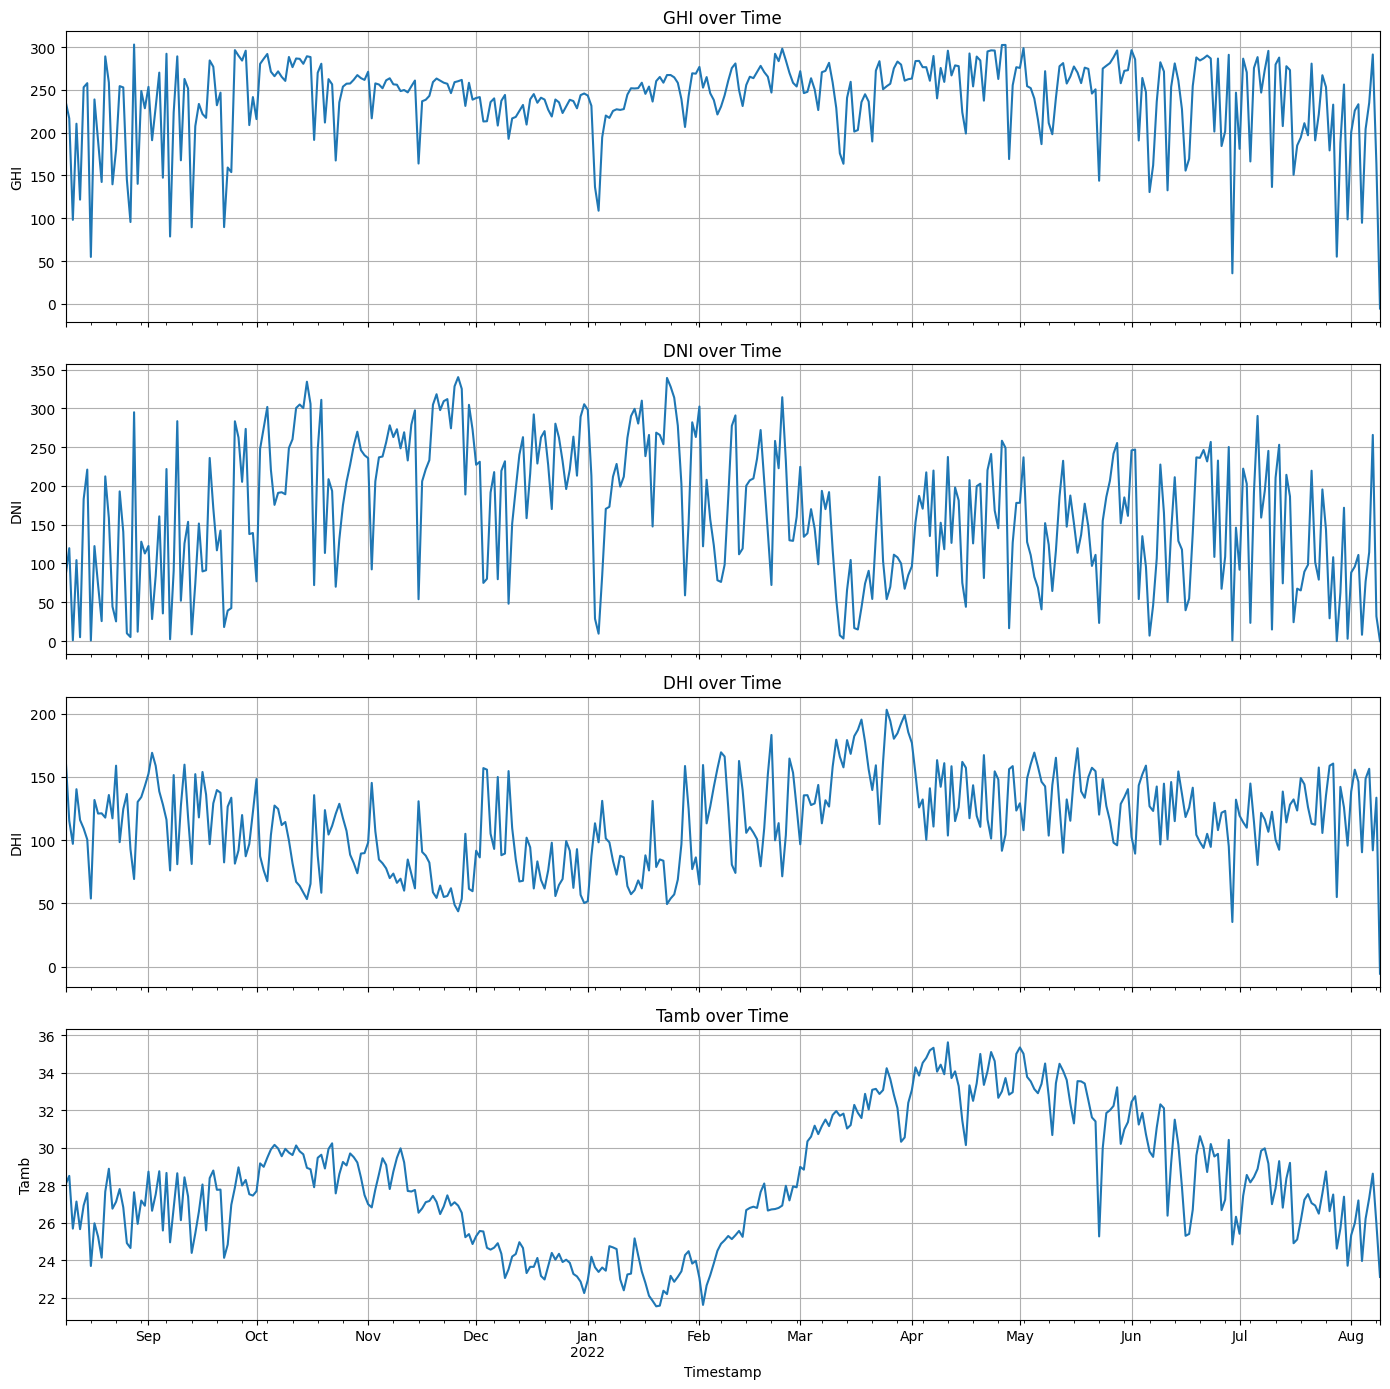

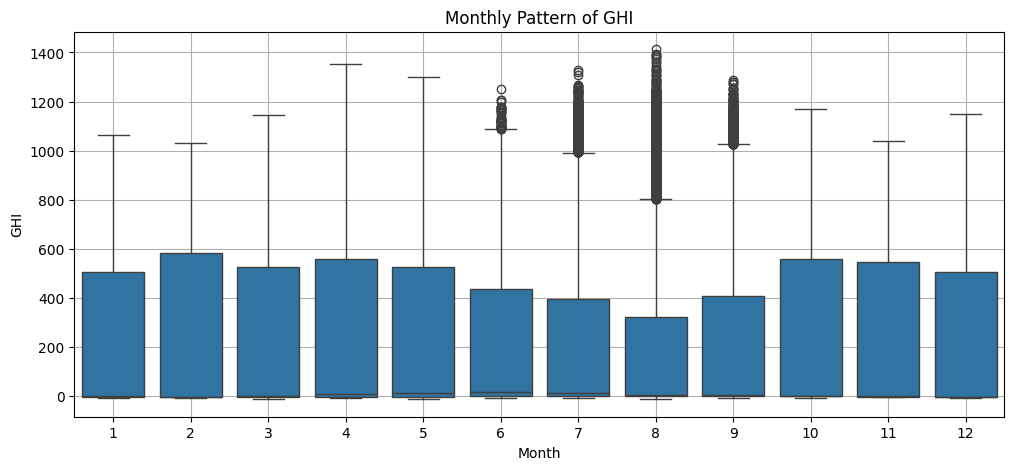

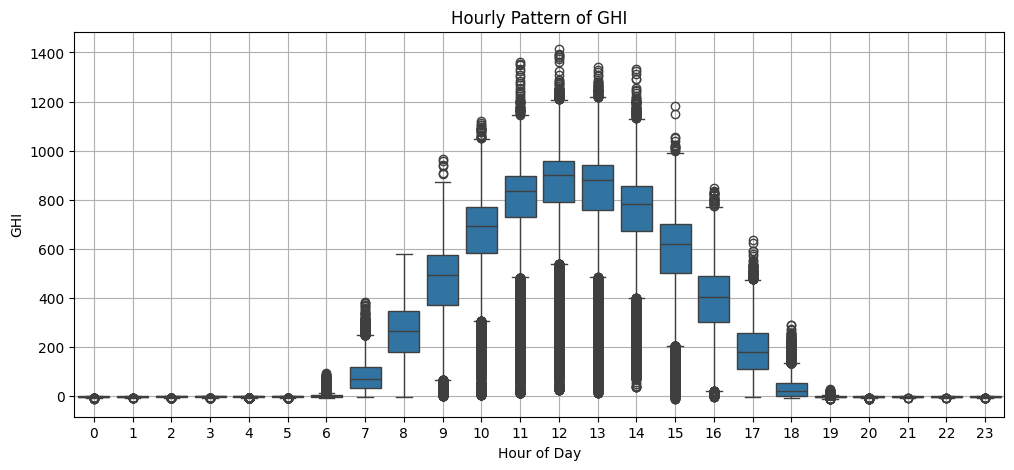

In [37]:
# Run the Time Series Analysis

# Setup for country
input_path = Config.DATA_PATH

# Initialize analyzer
analyzer = SolarTimeSeriesAnalyzer(input_path)

# Plot daily averages
analyzer.plot_time_series(columns=["GHI", "DNI", "DHI", "Tamb"], resample_freq='D')

# Monthly pattern of GHI
analyzer.plot_monthly_pattern(column="GHI")

# Hourly pattern of GHI
analyzer.plot_hourly_pattern(column="GHI")


Cleaning Impact

Group by Cleaning flag and plot average ModA & ModB pre/post-clean.

Timestamp parsed and set as index.


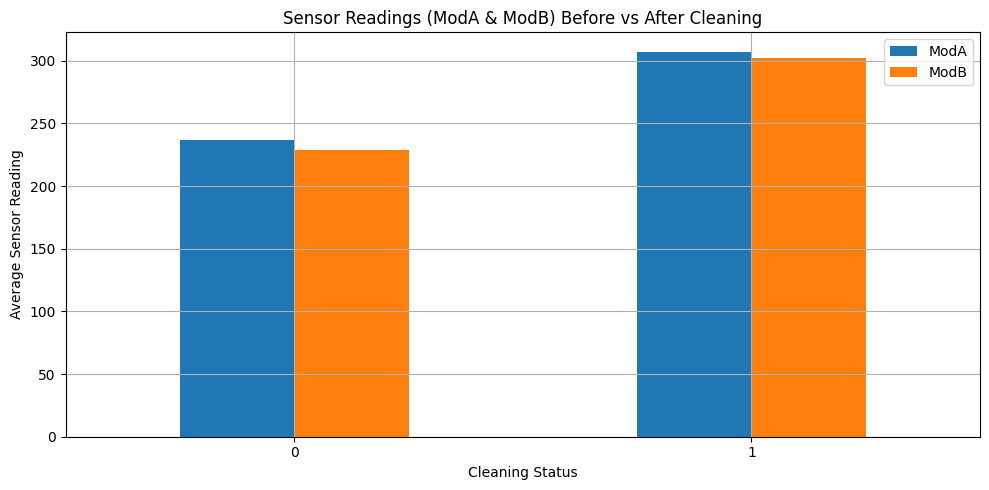

In [38]:
input_path = Config.DATA_PATH

# Initialize analyzer
analyzer = SolarTimeSeriesAnalyzer(input_path)

# Continue using the same object from previous steps
analyzer.plot_cleaning_impact()


Correlation & Relationship Analysis
Heatmap of correlations (GHI, DNI, DHI, TModA, TModB).

Scatter plots: WS, WSgust, WD vs. GHI; RH vs. Tamb or RH vs. GHI.


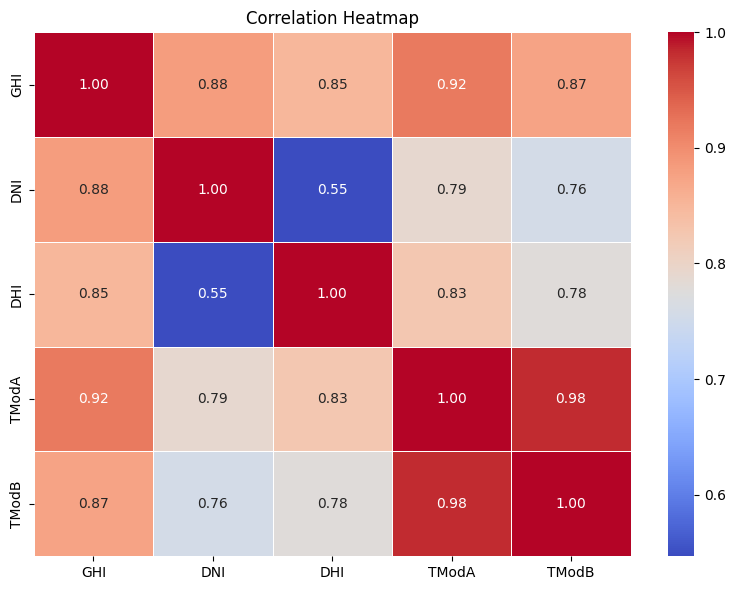

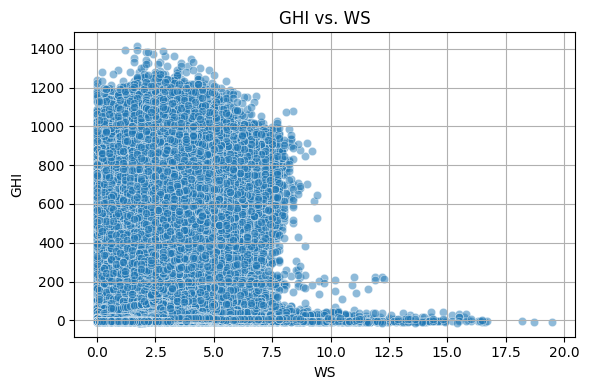

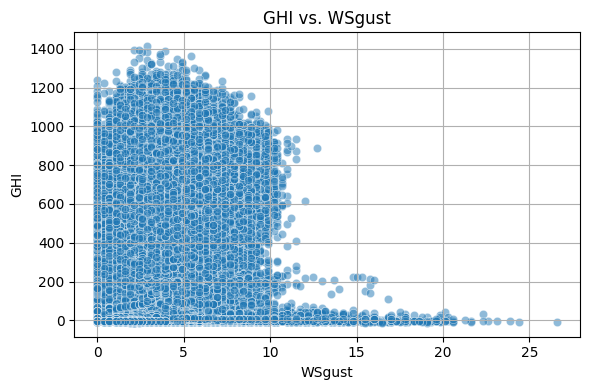

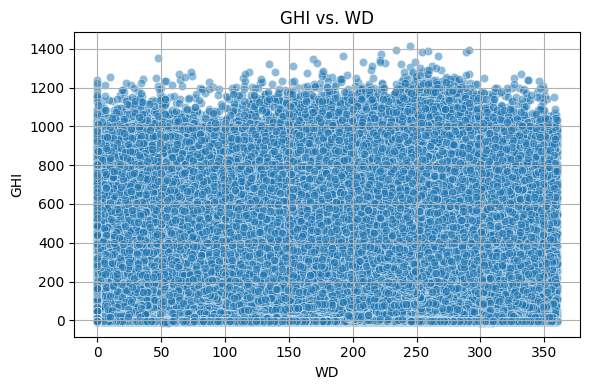

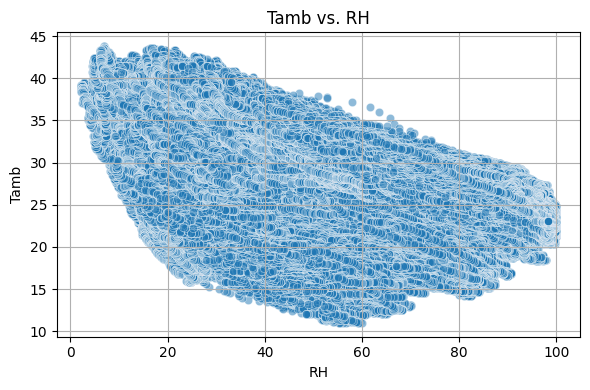

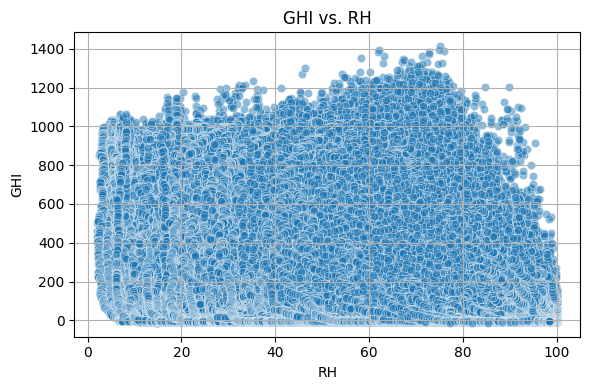

In [39]:
# Correlation heatmap
analyzer.plot_correlation_heatmap()

# Scatter plots for relationships
analyzer.plot_scatter_relationships()


Wind & Distribution Analysis
Wind rose or radial bar plot of WS/WD.

In [40]:

class WindDistributionAnalyzer(SolarTimeSeriesAnalyzer):
    def __init__(self, filepath, key_columns=None):
        super().__init__(filepath, key_columns)

 
    def plot_wind_rose(self):
        """
        Plots a wind rose using WS (wind speed) and WD (wind direction).
        """
        if 'WS' not in self.df.columns or 'WD' not in self.df.columns:
            print("⚠️ 'WS' or 'WD' column missing.")
            return

        ws = self.df['WS'].dropna()
        wd = self.df['WD'].dropna()

        common_idx = ws.index.intersection(wd.index)
        ws = ws.loc[common_idx]
        wd = wd.loc[common_idx]

        ax = WindroseAxes.from_ax()
        ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
        ax.set_title("🌬️ Wind Rose (WS vs WD)")
        ax.set_legend()
        plt.show()

    def plot_histograms(self, additional_variable='WS'):
        """
        Plots histograms for GHI and one additional variable (default: WS).
        """
        for var in ['GHI', additional_variable]:
            if var not in self.df.columns:
                print(f"⚠️ Column '{var}' not found.")
                continue

            plt.figure(figsize=(6, 4))
            sns.histplot(self.df[var].dropna(), kde=True, bins=30)
            plt.title(f"📊 Histogram of {var}")
            plt.xlabel(var)
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.tight_layout()
            plt.show()


In [41]:
wind_analyzer = WindDistributionAnalyzer(Config.DATA_PATH)

# Wind rose visualization
wind_analyzer.plot_wind_rose()

# Histogram visualization
wind_analyzer.plot_histograms()  # or wind_analyzer.plot_histograms('WSgust')


Timestamp parsed and set as index.


AttributeError: 'WindDistributionAnalyzer' object has no attribute 'plot_wind_rose'

Temperature Analysis
Examine how relative humidity (RH) might influence temperature readings and solar radiation.

#Influence of Relative Humidity (RH):

Temperature: Generally inverse relationship. Higher temperature means lower RH (air can hold more moisture). High RH makes warm temperatures feel hotter (less sweat evaporation).
Solar Radiation: Higher RH often leads to more scattering and absorption of sunlight due to water vapor, haze, and cloud formation (which RH is crucial for). This typically results in an inverse correlation: higher RH, lower solar radiation reaching the surface.
To analyze this in your data:

Correlations: Check how strongly RH is linearly related to temperature and solar radiation.
Scatter Plots: Visualize these relationships, potentially coloring points by the third variable (e.g., RH vs. Tamb colored by GHI).
Grouped Stats: Compare average temperature and solar radiation across different RH ranges (low, medium, high).

Bubble Chart
GHI vs. Tamb with bubble size = RH or BP.

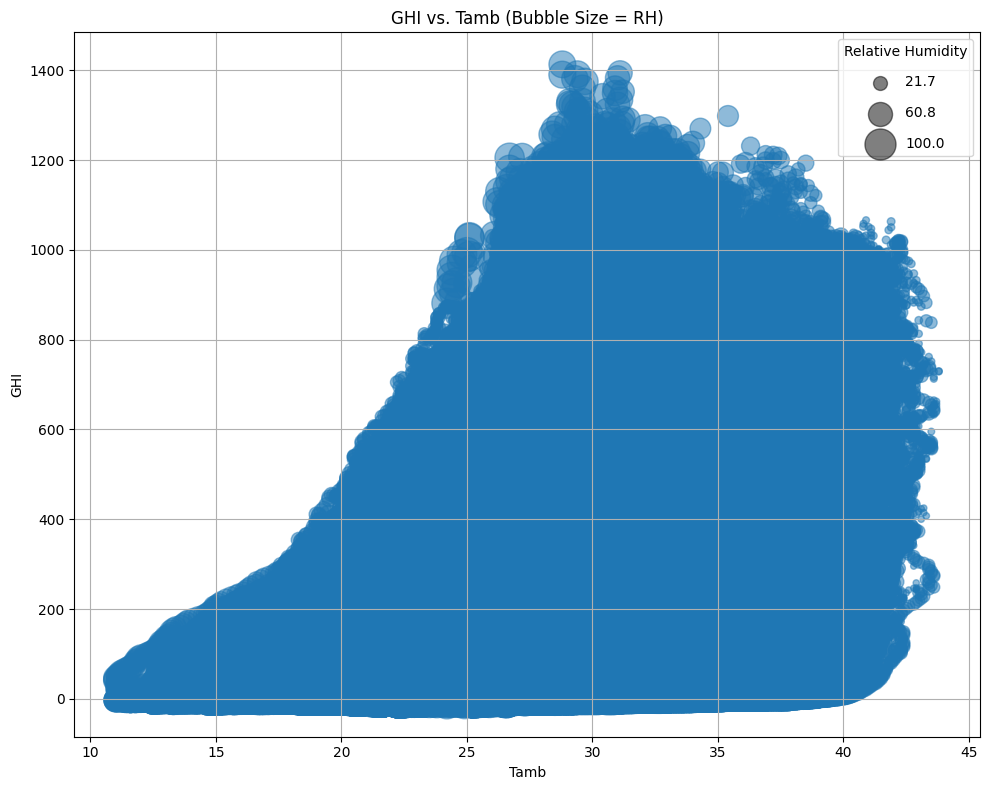

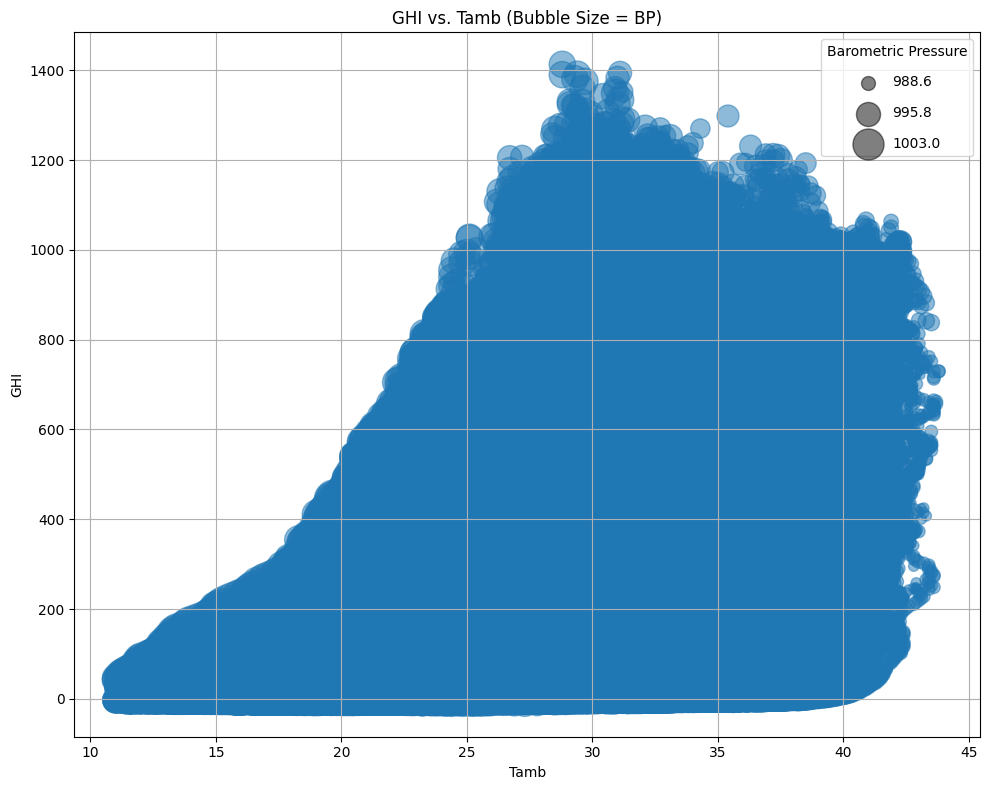

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_bubble_chart(df, x_col='Tamb', y_col='GHI', size_col=None, size_label='', title=''):
    """
    Generates a bubble chart to visualize the relationship between two variables,
    with bubble size representing a third variable.

    Args:
        df (pd.DataFrame): The input DataFrame.
        x_col (str, optional): The column name for the x-axis (e.g., 'Tamb').
                               Defaults to 'Tamb'.
        y_col (str, optional): The column name for the y-axis (e.g., 'GHI').
                               Defaults to 'GHI'.
        size_col (str, optional): The column name for the bubble size (e.g., 'RH' or 'BP').
                                 Defaults to None.
        size_label (str, optional): Label for the size legend. Defaults to ''.
        title (str, optional): The title of the plot. Defaults to ''.
    """

    if x_col not in df.columns or y_col not in df.columns:
        print(
            f"Error: DataFrame must contain columns '{x_col}' and '{y_col}'.")
        return

    plt.figure(figsize=(10, 8))

    if size_col:
        if size_col not in df.columns:
            print(f"Error: DataFrame must contain column '{size_col}'.")
            return

        # Normalize size to a reasonable range for plotting
        size = (df[size_col] - df[size_col].min()) / (df[size_col].max() -
                                                      df[size_col].min()) * 500  # Adjust 500 for bubble size
        scatter = plt.scatter(x=df[x_col], y=df[y_col], s=size, alpha=0.5)

        # Create a legend for the bubble sizes
        sizes = [100, 300, 500]  # Example sizes
        size_labels = [df[size_col].min() + (df[size_col].max() -
                                             df[size_col].min()) * s / 500 for s in sizes]
        for s, l in zip(sizes, size_labels):
            plt.scatter([], [], s=s, alpha=0.5, c='k', label=f'{l:.1f}')
        plt.legend(scatterpoints=1, labelspacing=1.2, title=size_label)

    else:
        plt.scatter(x=df[x_col], y=df[y_col], alpha=0.5)

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example Usage:
# Assuming your DataFrame is named 'df'


# 1. GHI vs. Tamb with bubble size = RH
plot_bubble_chart(df.copy(), x_col='Tamb', y_col='GHI', size_col='RH', size_label='Relative Humidity',
                  title='GHI vs. Tamb (Bubble Size = RH)')

# 2. GHI vs. Tamb with bubble size = BP
plot_bubble_chart(df.copy(), x_col='Tamb', y_col='GHI', size_col='BP', size_label='Barometric Pressure',
                  title='GHI vs. Tamb (Bubble Size = BP)')